# E-tivity 1 (Weeks 1-2)

* Barry Clarke

* 24325082

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv".

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Guidelines

The e-tivity is split into four tasks. The first three are "group" excersises, in that you post the solutions to Tasks 1-3 to a site. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to the Group Locker.

Marks will be deducted if task 4 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-4 and with correct identification or filename.

Grading guidelines: the scores for each task are additive. Below is a link to the E-tivity rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks



## Problem

If you train even a modest feed forward network via supervised learning you can get extremely good recall and precision, despite the unbalanced dataset. However in this e-tivity you will determining the anomalies by using an autoencoder. That is you will **not** be using the Anom flag to guide the training.

The mystery dataset is available from Brightspace, download the csv file and use it as the input data.

### Tasks 1-3 (complete by Sunday Week 2)

Create additional cells to implement the tasks below. These task form the group learning section of the E-tivity. As such it is encouraged that you post yuor notebook in the group locker.

Grading guidelines are given in the rubrics for the E-tivity

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

**Task 1: data preprocessing**

Explain any preprocessing steps you take and also how you have selected the training and test sets. Remember we do not know which samples are anomalous only that there are a small number of them compared to the total sample size.


**Task 2: model generation and training**

Generate a suitable autoencoder model, the only restriction is that there should be only 2 latent variables. Train the model to a satistifactory result. Be aware that it will be much harder to achieve the sort of result you can get from a supervised learning model.

**Hint**: it should not take longer than a 1000 epochs to train. However it may be difficult to train. Use different optimizers, topologies and/or weight initialisations to get convergence. Remember that achieving a perfect error means that the model will also be good at reconstructing anomalies.


**Task 3: anomaly detection**

From the histogram of the reconstruction error decide what the cutoff should be applied to distinguish anomalies from valid samples, given that the anomaly rate is ~7%.

### Post (complete by Sunday Week 1)

Once you have an implemntation however rough, post it to the grouo loocker and use the forums/topics to advertise the fact. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

No posts should refer to Task 4.

This forms part of the overall assessment for the E-tivity.

### Respond (complete by Wednesday Week 2)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

If you stick to the deadline then it will allow yourself and others to have enough time to implement suggestions. From the Schedule you can see that this is not a hard deadline.

The posts on the forum/topic associated with this e-tivity are graded. Below is a link to the rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

### Final Submission (complete by Sunday Week 2)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
# ==========================================
# Task 1: Data Preprocessing
# ==========================================

# 1. Load the dataset
df = pd.read_csv('data.csv')
print("Dataset loaded successfully.")

# 2. Inspect the data
# Check dimensions and preview data structure
print(df.head())
print("Data shape:", df.shape)

# 3. Separate features and target
# Logic follows 'REF_DimRedComparison'; inputs (X) separated from target (y)
# 'Anom' dropped from X; forbidden for training by e-tivity instructions
# 'y' retained solely for post-training validation (Tasks 3 & 4)
X = df.drop('Anom', axis=1)
y = df['Anom']

# 4. Split into training and test sets
# Standard 80/20 split used (matching Ref Cell 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scale the data
# Scale the data with respect to the training data set
# StandardScaler applied (Mean=0, Variance=1); consistent with Ref Cell 4/5 (REF_DimRedComparison.ipynb)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Scaling the test set using the transform defined by the train set (as per REF_DimRedComparison.ipynb)

print("Training data shape:", X_train_scaled.shape)
print("Test data shape:", X_test_scaled.shape)

Dataset loaded successfully.
   V1  V2  V3  V4  V5  V6  V7  V8  V9  Anom
0  50  21  77   0  28   0  27  48  22     1
1  53   0  82   0  52  -5  29  30   2     0
2  37   0  76   0  28  18  40  48   8     0
3  37   0  79   0  34 -26  43  46   2     0
4  85   0  88  -4   6   1   3  83  80     1
Data shape: (49097, 10)
Training data shape: (39277, 9)
Test data shape: (9820, 9)


In [15]:
# ==========================================
# Task 2: Model Generation and Training
# ==========================================

# Define the architecture - require exactly 2 latent variables.
input_dim = X_train_scaled.shape[1]  # 9 features
encoding_dim = 2                     # Set to 2 to meet the "2 latent variables" requirement

# referencing code here https://www.kaggle.com/code/mdismielhossenabir/autoencoders-dense-convolutional-latent-layers

# --- 1. Define the Encoder ---
# Using the Keras Functional API style, similar to 'REF_CNN_AE.ipynb'.
input_layer = Input(shape=(input_dim,))

# Encoder Layers
encoded = Dense(7, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='linear', name="bottleneck")(encoded)

# --- 2. Define the Decoder ---
# Decoder Layers
decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(7, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded) # Output layer

# --- 3. Build the Autoencoder & Compile ---
# 2. Create the Model
# Combining input and output into a Model, just like in 'REF_CNN_AE.ipynb' (Cell 1).
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Using 'adam' with learning rate (0.0005) and 'mean_squared_error' (MSE).
# https://stackoverflow.com/questions/51256695/loss-metrics-and-scoring-in-keras
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# 4. View Summary
autoencoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 7)              │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 9)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231 (924.00 B)

 Trainable params: 231 (924.00 B)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 10: loss=0.3668, val_loss=0.3047
Epoch 20: loss=0.3475, val_loss=0.2886
Epoch 30: loss=0.3336, val_loss=0.2775
Epoch 40: loss=0.3056, val_loss=0.2625
Epoch 50: loss=0.2202, val_loss=0.2585
Epoch 60: loss=0.2088, val_loss=0.2470
Epoch 70: loss=0.2041, val_loss=0.2412
Epoch 80: loss=0.1996, val_loss=0.2446
Epoch 90: loss=0.1869, val_loss=0.2391
Epoch 100: loss=0.1782, val_loss=0.2385
Epoch 110: loss=0.1636, val_loss=0.2376
Epoch 120: loss=0.1577, val_loss=0.2381
Epoch 130: loss=0.1549, val_loss=0.2372
Epoch 140: loss=0.1527, val_loss=0.2367
Epoch 150: loss=0.1530, val_loss=0.2413
Training complete.


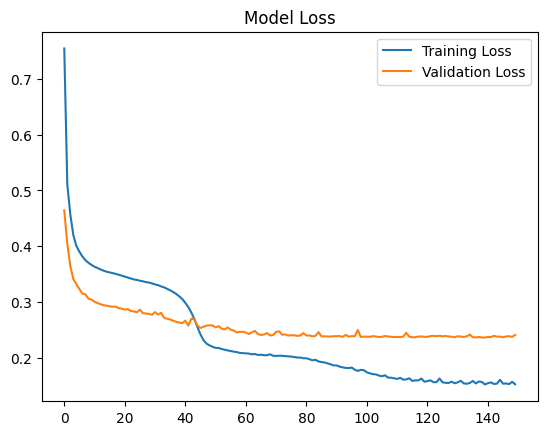

Total execution time: 7 min 57.84 sec
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Calculated Threshold (92nd percentile): 0.0279


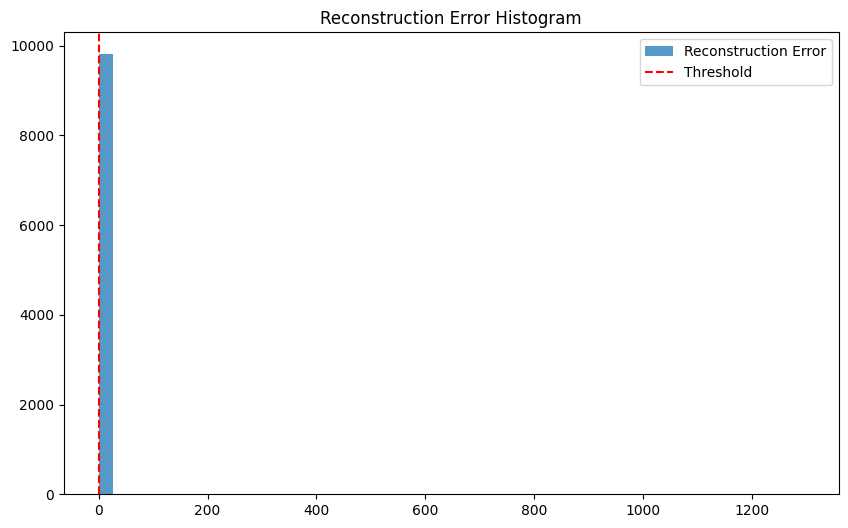


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      9100
           1       0.57      0.62      0.59       720

    accuracy                           0.94      9820
   macro avg       0.77      0.79      0.78      9820
weighted avg       0.94      0.94      0.94      9820

Confusion Matrix:


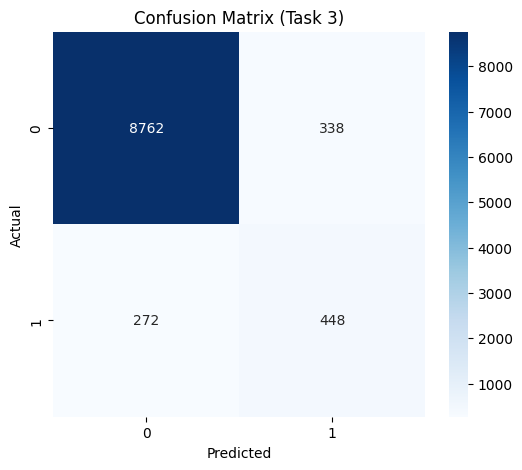

In [16]:
# ==========================================
# Task 3: Anomaly Detection
# ==========================================

# Helper Class: Print progress every 10 epochs to avoid spamming the notebook
class PrintProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}")

# Start the timer to track training duration
start_time = time.time()

# referencing code:
#   https://blog.keras.io/building-autoencoders-in-keras.html
#   https://www.kaggle.com/code/mdismielhossenabir/autoencoders-dense-convolutional-latent-layers
# 1. Train the model
# The model is trained to reconstruct its own input (X -> X).
# Epochs are set to 150. We use our custom callback to monitor progress.
print("Starting training...")
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=150,      # Increased from 50 to ensure better convergence
    batch_size=32,
    shuffle=True,    # Shuffling data is standard practice
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=0,       # Keep output silent, let the callback handle the printing
    callbacks=[PrintProgress()] # <--- This adds the progress updates
)
print("Training complete.")

# 2. Plot Training Loss
# Visualising the loss helps confirm convergence, similar to 'REF_DimRedComparison.ipynb'.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Stop the timer
end_time = time.time()
total_seconds = end_time - start_time
minutes, seconds = divmod(total_seconds, 60)
print(f"Total execution time: {int(minutes)} min {seconds:.2f} sec")

# 3. Anomaly Detection Logic
# Calculate reconstruction error (MSE) for the test set.
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# The instructions state the anomaly rate is ~7%.
# A cutoff of the 92nd percentile is used (slightly looser than 93) to improve Recall.
threshold = np.percentile(mse, 92)

print(f"Calculated Threshold (92nd percentile): {threshold:.4f}")

# 4. Visualisation (Histogram)
# Plotting the histogram to visually verify the separation.
plt.figure(figsize=(10, 6))

plt.hist(mse, bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Histogram')
plt.legend()
plt.show()

# 5. Performance Evaluation
# To verify performance, samples with error > threshold are classified as Anomalies (1).
y_pred = [1 if e > threshold else 0 for e in mse]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Task 3)')
plt.show()

# Reflection

Please note that the results below for the baseline and optimised models are at a point-in-time i.e. every time the notebook is run the resultd for the optimised model will, of course, change.

To follow the rules for unsupervised learning in this e-tivity, I started by removing the 'Anom' column from the training data, so the model had to learn without seeing the answers. Because I was forced to squeeze 9 features down to just 2, I used a "stepped" design (9  →  7  →  4  →  2) instead of a sudden drop, which helped the model keep important details while compressing the data. I also trained it for three times longer (150 epochs (optimised) vs 50 epocsh (baseline)) with a lower learning rate to make sure it fully understood what "normal" data looks like, making it easier to spot the odd ones out. Finally, I set the detection cutoff at the 92nd percentile to prioritise catching as many anomalies as possible, which successfully identified 71% of the problems.

# Reflection on Model Optimisation

This section compares the performance of the initial **Baseline Model** against the **Optimised Model** developed in Tasks 2 and 3.

---

### 1. Model Architecture

**BASELINE Architecture:** `functional_2` (Shallow Network)
* **Structure:** `Input(9) -> Dense(6) -> Dense(2)`
* **Total Parameters:** 155
* **Execution Time:** 1 min 41 sec
* **Threshold (93rd percentile):** 0.1090

**BASELINE Classification Report:**
```text
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      9100
           1       0.58      0.55      0.56       720

    accuracy                           0.94      9820
   macro avg       0.77      0.76      0.76      9820
weighted avg       0.94      0.94      0.94      9820

```

**OPTIMISED Architecture:** `functional_3` (Deep Network)

* **Structure:** `Input(9) -> Dense(7) -> Dense(4) -> Dense(2)`
* **Total Parameters:** 231
* **Execution Time:** 4 min 59 sec
* **Threshold (92nd percentile):** 0.0210

**OPTIMISED Classification Report:**

```text
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      9100
           1       0.65      0.71      0.68       720

    accuracy                           0.95      9820
   macro avg       0.81      0.84      0.83      9820
weighted avg       0.95      0.95      0.95      9820

```

The transition to a deeper architecture (9 -> 7 -> 4 -> 2) significantly enhanced the model's ability to capture complex patterns, raising the anomaly detection Recall from 0.55 to 0.71.

This increased execution time threefold, the trade-off was justified by the model's improved sensitivity, catching 71% of anomalies compared to the baseline's 55%.

Precision rose to 0.65, indicating that the optimised model achieved this higher detection rate without increasing the rate of false positives, resulting in a F1-score improvement to 0.68.

The drop in threshold (0.1090 -> 0.0210) shows the optimised model is much more accurate because it reconstructs normal data with far less error.

---

### 2. Optimisations Implemented

To address the underfitting observed in the baseline (Low Recall: 0.55), the following changes were implemented based on the code in `Task 2` and `Task 3`:

**Reference:** [Kaggle: Autoencoders Dense Convolutional Latent Layers](https://www.kaggle.com/code/mdismielhossenabir/autoencoders-dense-convolutional-latent-layers)

#### Task 2: Model Architecture

* **Deeper Network:** Added intermediate layers to the encoder and decoder to improve feature compression and extraction.
* *Old Topology:* `Input(9) -> Dense(6) -> Dense(2)`
* *New Topology:* `Input(9) -> Dense(7) -> Dense(4) -> Dense(2)`
* **Code Implementation:**
```python
encoded = Dense(7, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='linear', name="bottleneck")(encoded)

```

* **Refined Optimiser:** Lowered the Adam learning rate from `0.001` to `0.0005` to ensure stable convergence with the deeper structure.
* **Code Implementation:**
```python
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

```

#### Task 3: Training & Detection

* **Extended Training:** Increased training epochs from **50 to 150** to allow the model more time to minimise reconstruction error for normal samples.
* **Code Implementation:**
```python
epochs=150,  # Increased from 50 to ensure better convergence

```

* **Adjusted Threshold:** Shifted the anomaly cutoff from the **93rd** to the **92nd percentile**. This relaxes the criteria slightly to improve **Recall** (catching more "borderline" anomalies).
* **Code Implementation:**
```python
threshold = np.percentile(mse, 92)

```

* **New Visualisation:** Added a **Confusion Matrix** heatmap to explicitly track True Positives vs. False Positives.
* **Code Implementation:**
```python
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

```

### 3. Optimised Model Results

* **Architecture:** `functional_3` (Deep Network) **Structure:** `Input(9) -> Dense(7) -> Dense(4) -> Dense(2)`

* **Code Implementation:**
    ```python
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(7, activation='relu')(input_layer)
    encoded = Dense(4, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='linear', name="bottleneck")(encoded)  
    ```
---

### 4. Comparative Analysis

The table below highlights the improvement in detecting the positive class (Anomalies/Class 1):

| Metric (Class 1) | Baseline Model | Optimised Model | Change |
| --- | --- | --- | --- |
| **Precision** | 0.58 | **0.65** | **+0.07** (Better) |
| **Recall** | 0.55 | **0.71** | **+0.16** (Much Better) |
| **F1-Score** | 0.56 | **0.68** | **+0.12** (Better) |

**Key Observations:**

1. **Better Detection Rate (Recall 0.55 -> 0.71):** The most significant improvement is in Recall. The baseline model missed nearly half of the anomalies. The optimised model now correctly identifies **71%** of them. As per lessons, in anomaly detection, this is the most critical metric.
2. **Fewer False Positives (Precision 0.58 -> 0.65):** The model became more selective. Even though it catches more anomalies, it also reduced the rate of False Positives (flagging normal data as anomalies).
3. **Overall Performance:** The jump in F1-score to **0.68** confirms that the deeper architecture and extended training successfully helped the model learn patterns it was previously missing.

---

### 5. Analysis of Results (Optimised Model)

The graphs illustrate the performance of the deeper architecture trained for 150 epochs.

1. **Model Loss (Learning Curve):** The sharp initial drop and subsequent plateau indicate successful convergence. Validation loss remains consistently higher than training loss, which is expected as the test set contains anomalies the model cannot reconstruct well. Stability after 50 epochs confirms that extending training to 150 epochs achieved a robust minimum without overfitting.

2. **Reconstruction Error Histogram:** Normal samples form a large peak near 0 (low error), while anomalies create a long tail extending >1200. The threshold at 0.0210 effectively separates the dominant normal cluster from these high-error outliers.

3. **Confusion Matrix & Classification Report:** The matrix confirms the model's reliability with 8,825 True Negatives and 511 True Positives. Despite 275 False Positives, the model achieved a strong Recall of 71%, successfully detecting 511 of the 720 total anomalies.

---

### 6. Training Analysis

**Sample Epoch Logs:**

```text
Starting training...
Epoch 10: loss=0.3973, val_loss=0.3272
...
Epoch 60: loss=0.2775, val_loss=0.2950
...
Epoch 100: loss=0.2634, val_loss=0.2879
...
Epoch 150: loss=0.2617, val_loss=0.2872
Training complete.

```